In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

# Path to zip file
zip_path = '/content/drive/MyDrive/8Birds.zip'

# Destination folder
extract_to = '/content/8bird'

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


In [ ]:
import os

new_folder = '8bird/8Birds'

for subfolder in os.listdir(new_folder):
    path = os.path.join(new_folder, subfolder)
    if os.path.isdir(path):
        png_count = sum(1 for file in os.listdir(path) if file.lower().endswith('.png'))
        print(f"{subfolder}: {png_count} PNG file(s)")


houspa: 2200 PNG file(s)
asikoe2: 2012 PNG file(s)
lirpo: 2089 PNG file(s)
whiter2: 2044 PNG file(s)
blakit1: 1911 PNG file(s)
rorpar: 2124 PNG file(s)
commyn: 2200 PNG file(s)
comkin1: 2187 PNG file(s)


## **EDA**

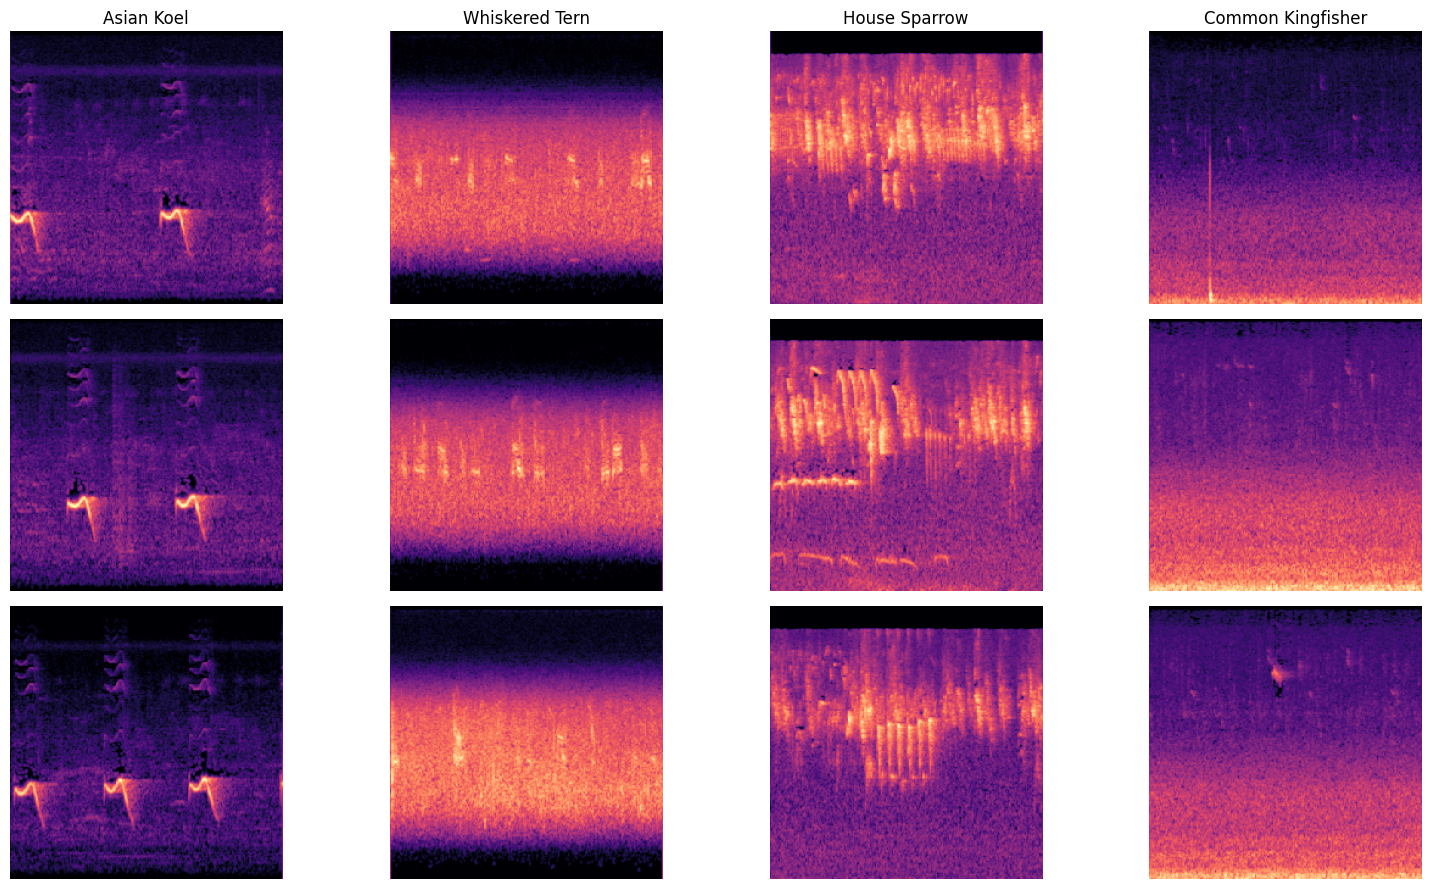

In [87]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Folder path and mapping
base_folder = '8bird/8Birds'
label_to_name = {
    "houspa": "House Sparrow",
    "asikoe2": "Asian Koel",
    "lirpo": "Little Ringed Plover",
    "whiter2": "Whiskered Tern",
    "blakit1": "Black Kite",
    "rorpar": "Rose-ringed Parakeet",
    "commyn": "Common Myna",
    "comkin1": "Common Kingfisher"
}

selected_birds = ['asikoe2', 'whiter2', 'houspa', 'comkin1']  # Asian Koel first

plt.figure(figsize=(16, 9))  # 4 columns × 3 rows

for col_idx, label in enumerate(selected_birds):
    bird_folder = os.path.join(base_folder, label)
    image_files = sorted([f for f in os.listdir(bird_folder) if f.lower().endswith('.png')])

    selected_images = image_files[3:6]  # First 3 images only

    for row_idx, image_file in enumerate(selected_images):
        img_path = os.path.join(bird_folder, image_file)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plot_idx = row_idx * 4 + col_idx + 1
        plt.subplot(3, 4, plot_idx)
        plt.imshow(img_rgb)
        if row_idx == 0:
            plt.title(label_to_name.get(label, label))  # Bird name
        plt.axis('off')

plt.tight_layout()
plt.show()

# **Model**

In [ ]:
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split

# Define your root folder
root_folder = '8bird/8Birds'

# Choose exactly 10 birds
selected_birds = ['asikoe2', 'blakit1','comkin1','commyn','houspa','lirpo','rorpar','whiter2']

image_paths = []
labels = []

for bird_class in selected_birds:
    class_path = os.path.join(root_folder, bird_class)
    if os.path.isdir(class_path):
        images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith('.png')]

        selected_images = random.sample(images, min(2000, len(images)))

        image_paths.extend(selected_images)
        labels.extend([bird_class] * len(selected_images))

df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

df.to_csv('8birds.csv', index=False)

print("CSV created for 8 birds with", len(df), "entries.")

# Split into train (90%) and Val (10%)
train_df, val_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)

# Check the class distribution
print("Train distribution:\n", train_df['label'].value_counts())
print("Validation distribution:\n", val_df['label'].value_counts())

# Save the splits to CSV
train_df.to_csv('train_split.csv', index=False)
val_df.to_csv('val_split.csv', index=False)

CSV created for 8 birds with 15911 entries.
Train distribution:
 label
houspa     1800
comkin1    1800
rorpar     1800
asikoe2    1800
whiter2    1800
commyn     1800
lirpo      1800
blakit1    1719
Name: count, dtype: int64
Validation distribution:
 label
asikoe2    200
whiter2    200
houspa     200
commyn     200
comkin1    200
rorpar     200
lirpo      200
blakit1    192
Name: count, dtype: int64


In [ ]:
df

,image_path,label
0,/kaggle/input/indiasbirds8/8Birds/8Birds/asiko...,asikoe2
1,/kaggle/input/indiasbirds8/8Birds/8Birds/asiko...,asikoe2
2,/kaggle/input/indiasbirds8/8Birds/8Birds/asiko...,asikoe2
3,/kaggle/input/indiasbirds8/8Birds/8Birds/asiko...,asikoe2
4,/kaggle/input/indiasbirds8/8Birds/8Birds/asiko...,asikoe2
...,...,...
15906,/kaggle/input/indiasbirds8/8Birds/8Birds/white...,whiter2
15907,/kaggle/input/indiasbirds8/8Birds/8Birds/white...,whiter2
15908,/kaggle/input/indiasbirds8/8Birds/8Birds/white...,whiter2
15909,/kaggle/input/indiasbirds8/8Birds/8Birds/white...,whiter2


In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Define data augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    fill_mode='nearest'
)

# For validation and test, only rescale the images
val_datagen = ImageDataGenerator(rescale=1./255)

val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)
#generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)



Found 14319 validated image filenames belonging to 8 classes.
Found 1592 validated image filenames belonging to 8 classes.


## How transformation works(sample)

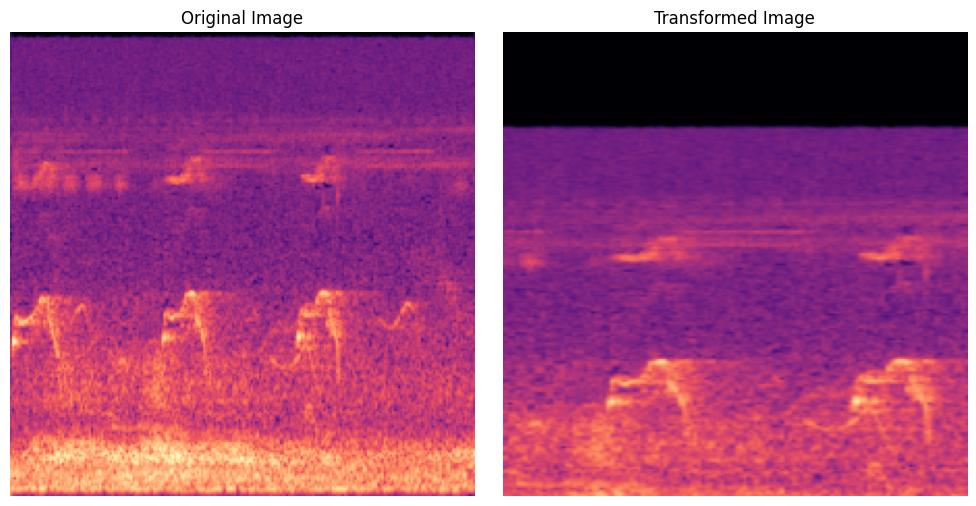

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Initialize ImageDataGenerator with transformations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.7,
    fill_mode='nearest'
)

img = load_img('/content/6bird/6birds/asikoe2/asikoe2_100_2.png')
img_array = img_to_array(img)
img_array = img_array.reshape((1, ) + img_array.shape)

it = train_datagen.flow(img_array, batch_size=1)

transformed_img = next(it)[0]
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Transformed Image
plt.subplot(1, 2, 2)
plt.imshow(transformed_img)
plt.title('Transformed Image')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# test_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow_from_dataframe(
#     test_df,
#     x_col='image_path',
#     y_col='label',
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='categorical',
#     shuffle=False
# )


## **Model Building**

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

classes_to_predict = selected_birds

input_shape = (224, 224, 3)

effnet_layers = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in effnet_layers.layers[:20]:
    layer.trainable = False

for layer in effnet_layers.layers[20:]:
    layer.trainable = True

model = models.Sequential()
model.add(effnet_layers)
model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(256, use_bias=False))
model.add(layers.Activation('relu'))

model.add(layers.Dense(len(classes_to_predict), activation="softmax"))
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         327,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,379,307 (16.71 MB)

 Trainable params: 4,333,180 (16.53 MB)

 Non-trainable params: 46,127 (180.19 KB)

## **Normalization**

In [ ]:
import numpy as np
from PIL import Image
from tqdm import tqdm

means = []
stds = []

for path in tqdm(train_df['image_path']):
    img = Image.open(path).convert('RGB')
    img = img.resize((224, 224))  # Ensure same size
    img_array = np.array(img) / 255.0  # Normalize to [0, 1]
    means.append(np.mean(img_array, axis=(0, 1)))
    stds.append(np.std(img_array, axis=(0, 1)))

mean = np.mean(means, axis=0)
std = np.mean(stds, axis=0)

print("Mean:", mean)
print("Std:", std)

def custom_normalization(image):
    return (image - mean) / std

100%|██████████| 9120/9120 [01:00<00:00, 150.89it/s]

Mean: [0.56320248 0.20063071 0.41080919]
Std: [0.22682047 0.11753299 0.10818759]


In [ ]:
# def custom_normalization(img):
#     img = img / 255.0  # Scale to [0, 1]
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     return (img - mean) / std
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    preprocessing_function=custom_normalization,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=custom_normalization)
test_datagen = ImageDataGenerator(preprocessing_function=custom_normalization)

# Prepare the generators for data loading from DataFrame
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


NameError: name 'custom_normalization' is not defined

## Continue

In [ ]:
import os
import shutil
import heapq
import tensorflow as tf

class TopKModelSaver(tf.keras.callbacks.Callback):
    def __init__(self, save_dir, k=3):
        super().__init__()
        self.save_dir = save_dir
        self.k = k
        self.saved_models = []

        self.best_dir = os.path.join(save_dir, 'best')
        os.makedirs(self.best_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if val_loss is None:
            print("val_loss is None, skipping save")
            return

        filename = f"model_{epoch + 1:02d}_val_loss_{val_loss:.4f}.keras"
        full_path = os.path.join(self.save_dir, filename)
        self.model.save(full_path)

        heapq.heappush(self.saved_models, (val_loss, full_path))

    def on_train_end(self, logs=None):
        # Keep only the top-k models
        top_k_models = heapq.nsmallest(self.k, self.saved_models)

        # Refresh best/ directory at end of training
        for f in os.listdir(self.best_dir):
            os.remove(os.path.join(self.best_dir, f))
        for _, path in top_k_models:
            shutil.copy(path, os.path.join(self.best_dir, os.path.basename(path)))


In [ ]:
import numpy as np
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import LearningRateScheduler

def step_lr_schedule(epoch, lr):
    decay_factor = 0.5
    step_size = 10
    if epoch > 0 and epoch % step_size == 0:
        return lr * decay_factor  # Use current lr instead of resetting to initial
    return lr

lr_scheduler = LearningRateScheduler(step_lr_schedule, verbose=1)


checkpoint_callback = ModelCheckpoint(
    filepath='models/model_{epoch:02d}_val_loss_{val_loss:.4f}.keras',
    monitor='val_loss',
    save_best_only=False,
    mode='min',
    save_freq='epoch'
)

# Define additional callbacks
callbacks = [
    lr_scheduler,
    EarlyStopping(monitor='val_loss', patience=5),
    checkpoint_callback,
    TopKModelSaver(save_dir='models', k=3)
]

optimizer = Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

In [ ]:

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/30


E0000 00:00:1748462118.258124      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748462118.446524      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748462118.918091      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748462119.124063      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748462119.486951      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

277/448 ━━━━━━━━━━━━━━━━━━━━ 1:09 407ms/step - accuracy: 0.4290 - loss: 1.5843

E0000 00:00:1748462259.141608      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748462259.326150      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748462259.754539      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748462259.959053      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748462260.304714      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

448/448 ━━━━━━━━━━━━━━━━━━━━ 308s 511ms/step - accuracy: 0.4945 - loss: 1.4218 - val_accuracy: 0.1407 - val_loss: 2.2370 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 190s 424ms/step - accuracy: 0.7811 - loss: 0.6528 - val_accuracy: 0.6369 - val_loss: 1.1489 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 188s 419ms/step - accuracy: 0.8273 - loss: 0.5115 - val_accuracy: 0.8417 - val_loss: 0.4706 - learning_rate: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 198s 442ms/step - accuracy: 0.8617 - loss: 0.4320 - val_accuracy: 0.8040 - val_loss: 0.5735 - learning_rate: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 222s 496ms/

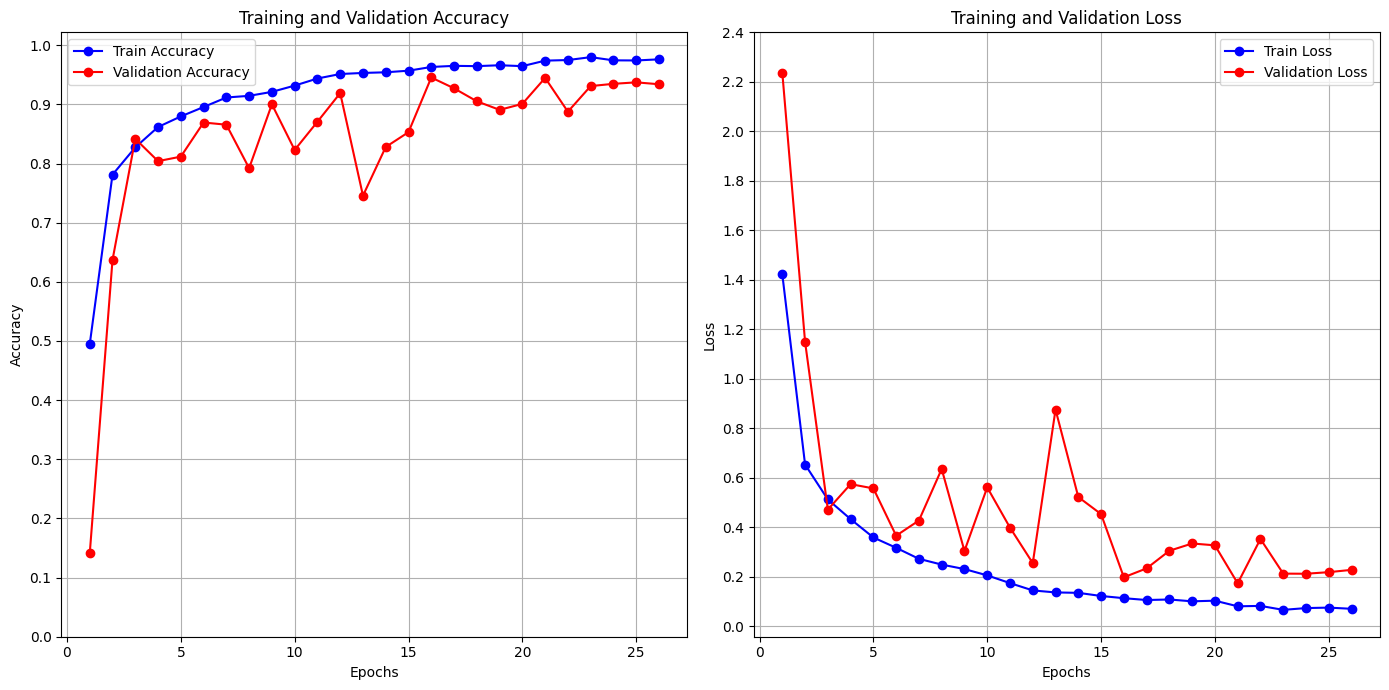

In [ ]:

plt.figure(figsize=(14, 7))

# Plot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.grid(True)
plt.legend()

#loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

plt.yticks(np.arange(0.0, 2.5, 0.2))
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## **Validation Accuracy and confusion matrix**

In [ ]:
model = tf.keras.models.load_model('final_model.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


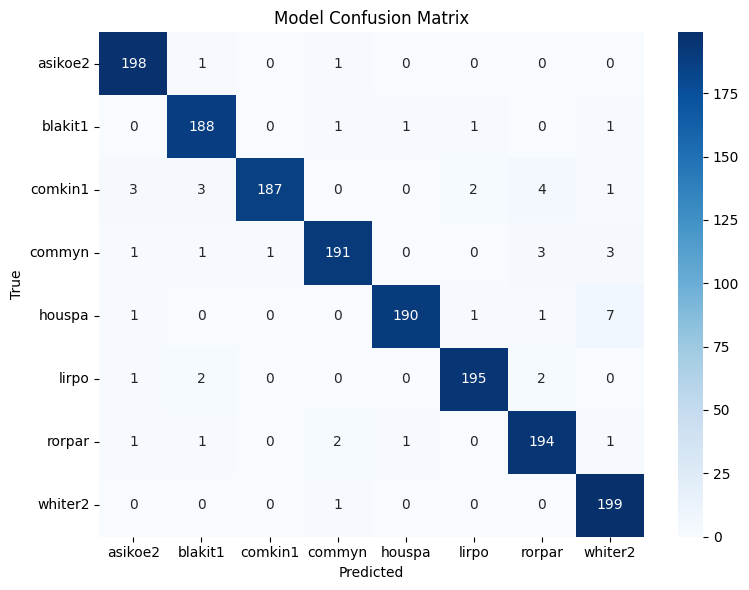

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def get_conf_matrix(model_path, val_generator):
    preds = model.predict(val_generator, verbose=0)
    y_true = val_generator.classes
    y_pred = np.argmax(preds, axis=1)
    return confusion_matrix(y_true, y_pred)

cm = get_conf_matrix(model, val_generator)
labels = list(val_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
import numpy as np

def evaluate_model(model_path, val_generator):
    preds = model.predict(val_generator, verbose=0)
    y_true = val_generator.classes
    y_pred = np.argmax(preds, axis=1)

    report = classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys(), output_dict=True)
    accuracy = accuracy_score(y_true, y_pred)

    precision = np.mean([v["precision"] for k, v in report.items() if k not in ['accuracy', 'macro avg', 'weighted avg']])
    recall = np.mean([v["recall"] for k, v in report.items() if k not in ['accuracy', 'macro avg', 'weighted avg']])
    f1 = np.mean([v["f1-score"] for k, v in report.items() if k not in ['accuracy', 'macro avg', 'weighted avg']])

    return accuracy, precision, recall, f1

acc1, prec1, rec1, f1_1 = evaluate_model(model, val_generator)

print(f"Accuracy: {acc1:.4f}, Precision: {prec1:.4f}, Recall: {rec1:.4f}, F1-Score: {f1_1:.4f}\n")


Accuracy: 0.9686, Precision: 0.9692, Recall: 0.9686, F1-Score: 0.9686



## **Histogram of predictions**

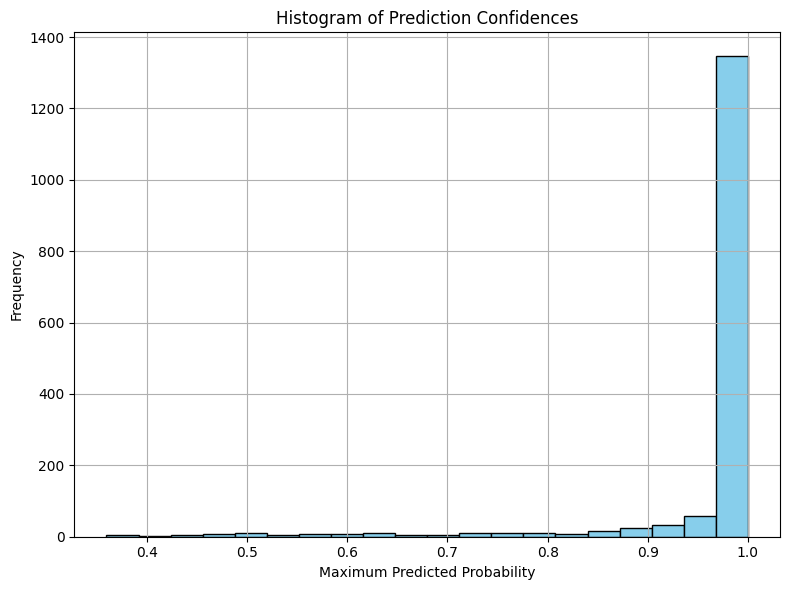

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get predictions from your model (assuming softmax output)


preds = model.predict(val_generator, verbose=0)

# Max softmax probability per sample = model confidence
confidences = np.max(preds, axis=1)

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(confidences, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Prediction Confidences')
plt.xlabel('Maximum Predicted Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


## **External Test Dataset**

In [ ]:
import zipfile

# Path to zip file
zip_path = '/content/drive/MyDrive/test_images8.zip'

# Destination folder
extract_to = './test/'

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


In [ ]:
import os
import pandas as pd

# Define the path to the external test data
test_root_folder = '/content/test/test_images8'
selected_birds = ['asikoe2', 'blakit1','comkin1','commyn','houspa','lirpo','rorpar','whiter2']

test_image_paths = []
test_labels = []

for bird_class in selected_birds:
    class_path = os.path.join(test_root_folder, bird_class)
    if os.path.isdir(class_path):
        images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith('.png')]

        test_image_paths.extend(images)
        test_labels.extend([bird_class] * len(images))

test_df = pd.DataFrame({
    'image_path': test_image_paths,
    'label': test_labels
})

test_df.to_csv('test_split.csv', index=False)
print("Test CSV created with", len(test_df), "entries.")


Test CSV created with 783 entries.


In [ ]:
test_df

,image_path,label
0,/content/test/test_images8/asikoe2/asikoe282.png,asikoe2
1,/content/test/test_images8/asikoe2/asikoe221.png,asikoe2
2,/content/test/test_images8/asikoe2/asikoe264.png,asikoe2
3,/content/test/test_images8/asikoe2/asikoe287.png,asikoe2
4,/content/test/test_images8/asikoe2/asikoe285.png,asikoe2
...,...,...
778,/content/test/test_images8/whiter2/whiter2_17_...,whiter2
779,/content/test/test_images8/whiter2/whiter2_26_...,whiter2
780,/content/test/test_images8/whiter2/whiter2_26_...,whiter2
781,/content/test/test_images8/whiter2/whiter2_26_...,whiter2


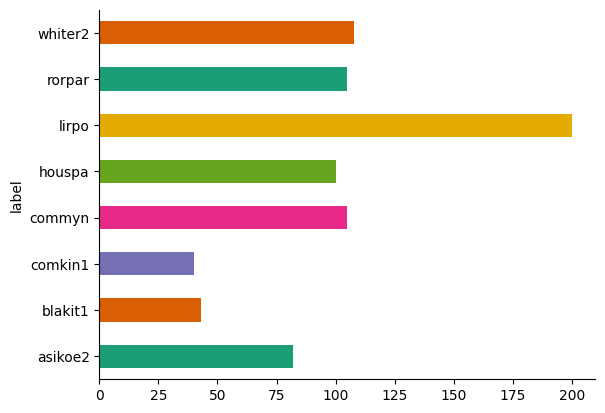

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
test_df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 783 validated image filenames belonging to 8 classes.


In [ ]:
model = tf.keras.models.load_model('model_21_val_loss_0.1726.keras')
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 294ms/step - accuracy: 0.8392 - loss: 0.7054
Test Accuracy: 89.02%


25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 435ms/step


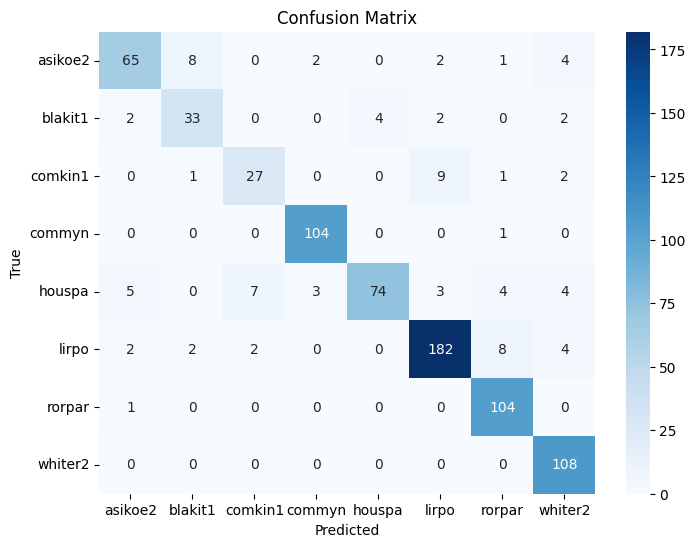

Classification Report:
              precision    recall  f1-score   support

     asikoe2       0.87      0.79      0.83        82
     blakit1       0.75      0.77      0.76        43
     comkin1       0.75      0.68      0.71        40
      commyn       0.95      0.99      0.97       105
      houspa       0.95      0.74      0.83       100
       lirpo       0.92      0.91      0.91       200
      rorpar       0.87      0.99      0.93       105
     whiter2       0.87      1.00      0.93       108

    accuracy                           0.89       783
   macro avg       0.87      0.86      0.86       783
weighted avg       0.89      0.89      0.89       783


Overall Metrics (Average per Class):
Accuracy: 0.8902
Precision: 0.8667
Recall: 0.8583
F1-Score: 0.8593


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Get true labels and predictions from the test generator
test_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get class names from the generator
class_names = list(test_generator.class_indices.keys())

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Generate and print the classification report
report = classification_report(test_labels, predicted_classes, target_names=class_names)
print("Classification Report:")
print(report)

# Calculate overall metrics (from the classification report)
overall_accuracy = accuracy_score(test_labels, predicted_classes)
report_dict = classification_report(test_labels, predicted_classes, target_names=class_names, output_dict=True)

# Average precision, recall, and f1-score across all classes (excluding macro/weighted averages)
precision = np.mean([v["precision"] for k, v in report_dict.items() if k not in ['accuracy', 'macro avg', 'weighted avg']])
recall = np.mean([v["recall"] for k, v in report_dict.items() if k not in ['accuracy', 'macro avg', 'weighted avg']])
f1 = np.mean([v["f1-score"] for k, v in report_dict.items() if k not in ['accuracy', 'macro avg', 'weighted avg']])


print("\nOverall Metrics (Average per Class):")
print(f"Accuracy: {overall_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# **Testing with Audio**

In [ ]:
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tempfile
from PIL import Image

# Load your trained model
#model = tf.keras.models.load_model('/content/models/best/model_14_val_loss_0.2422.keras')  # update if needed

# Define the mapping of class indices to bird names
class_dict = {
    0: 'Asian Koel',
    1: 'Black Kite',
    2: 'Common Kingfisher',
    3: 'Common Myna',
    4: 'House Sparrow',
    5: 'Little Ringed Plover',
    6: 'Rose Ringed Paraket',
    7: 'Whiskered Tern'

}

def predict_from_ogg(file_path):
    waveform, sr = librosa.load(file_path, sr=None)
    waveform_trimmed, _ = librosa.effects.trim(waveform, top_db=20)
    total_duration = librosa.get_duration(y=waveform_trimmed, sr=sr)
    num_chunks = int(total_duration // 5)

    class_predictions = np.zeros(model.output_shape[1])

    for i in range(num_chunks):
        start_sample = int(i * 5 * sr)
        end_sample = start_sample + int(5.0 * sr)
        waveform_5sec = waveform_trimmed[start_sample:end_sample]

        mel_spectrogram = librosa.feature.melspectrogram(
            y=waveform_5sec, sr=sr, n_mels=224, hop_length=512
        )
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmpfile:
            fig, ax = plt.subplots(figsize=(2.24, 2.24), dpi=100)
            ax.axis('off')
            librosa.display.specshow(mel_spectrogram_db, sr=sr, hop_length=512, cmap='magma')
            plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
            plt.savefig(tmpfile.name, bbox_inches='tight', pad_inches=0)
            plt.close()

            img = Image.open(tmpfile.name).convert('RGB')
            img = img.resize((224, 224))
            img_array = np.array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array, verbose=0)
        class_predictions += prediction[0]
        print(f"Prediction for chunk {i+1}: {prediction}")

    predicted_class = np.argmax(class_predictions)
    print(f"\nPredicted class index: {predicted_class}")
    print(f"Predicted bird name: {class_dict[predicted_class]}")
    print("\nCumulative predictions for all classes:")
    for i, score in enumerate(class_predictions):
        print(f"{class_dict[i]} ({i}): {score:.4f}")

    return predicted_class, class_predictions

# Test with an example file
file_path = "XC74356.ogg"  # Make sure the file exists at this path
predicted_class, class_predictions = predict_from_ogg(file_path)


Prediction for chunk 1: [[1.2778339e-07 5.1591093e-07 3.8785331e-07 1.7197966e-06 4.0072226e-07
  1.2171718e-07 9.9999654e-01 2.8024402e-07]]
Prediction for chunk 2: [[1.0217077e-08 7.5404472e-08 1.6865631e-07 2.4731582e-05 1.4783556e-05
  1.8996413e-08 9.9914479e-01 8.1545173e-04]]
Prediction for chunk 3: [[3.9859981e-07 4.6824834e-06 3.4111890e-06 1.8969358e-05 9.5288551e-06
  4.7573765e-05 9.9743015e-01 2.4852825e-03]]
Prediction for chunk 4: [[3.0137755e-06 1.0231648e-05 4.4652829e-06 2.6172842e-03 4.4911709e-02
  7.6012748e-06 4.4850630e-01 5.0393939e-01]]
Prediction for chunk 5: [[1.8625002e-05 1.7821269e-05 1.1749000e-06 1.5302360e-03 4.6492269e-04
  1.7035576e-05 9.9708587e-01 8.6429896e-04]]
Prediction for chunk 6: [[1.0513604e-03 3.2453757e-04 3.3138127e-05 9.2116576e-03 7.3116414e-02
  1.1744032e-05 9.1206592e-01 4.1851848e-03]]
Prediction for chunk 7: [[2.7200576e-05 9.1968792e-07 2.1638125e-06 1.9604719e-05 1.9324110e-05
  4.4519114e-05 9.9967146e-01 2.1493256e-04]]
Predic

In [ ]:
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tempfile
from PIL import Image

def predict_from_ogg(file_path):
    waveform, sr = librosa.load(file_path, sr=None)
    waveform_trimmed, _ = librosa.effects.trim(waveform, top_db=20)
    total_duration = librosa.get_duration(y=waveform_trimmed, sr=sr)
    num_chunks = int(total_duration // 5)

    class_predictions = np.zeros(model.output_shape[1])

    for i in range(num_chunks):
        start_sample = int(i * 5 * sr)
        end_sample = start_sample + int(5.0 * sr)
        waveform_5sec = waveform_trimmed[start_sample:end_sample]

        mel_spectrogram = librosa.feature.melspectrogram(
            y=waveform_5sec, sr=sr, n_mels=224, hop_length=512
        )
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmpfile:
            fig, ax = plt.subplots(figsize=(2.24, 2.24), dpi=100)
            ax.axis('off')
            librosa.display.specshow(mel_spectrogram_db, sr=sr, hop_length=512, cmap='magma')
            plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
            plt.savefig(tmpfile.name, bbox_inches='tight', pad_inches=0)
            plt.close()

            img = Image.open(tmpfile.name).convert('RGB')
            img = img.resize((224, 224))
            img_array = np.array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array)
        class_predictions += prediction[0]

        print(f"Prediction for chunk {i+1}: {prediction}")

    predicted_class = np.argmax(class_predictions)
    return predicted_class, class_predictions



asikoe2 test

In [ ]:
# Define the class mapping
class_map = {
    0: 'asikoe2',
    1: 'blakit1',
    2: 'comgre',
    3: 'comkin1',
    4: 'rorpar',
    5: 'whiter2'
}

file_path = "/content/Testaudio/asian_koel1.ogg"
predicted_class, class_predictions = predict_from_ogg(file_path)
bird_name = class_map[predicted_class]

print(f"Predicted class: {bird_name}")
print(f"Cumulative predictions for all classes: {class_predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction for chunk 1: [[9.9999964e-01 6.3073891e-08 2.6504690e-08 3.3486668e-08 2.1329365e-07
  1.1911764e-08]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for chunk 2: [[1.0000000e+00 2.6052045e-09 5.8085969e-10 1.4774851e-10 6.2278527e-10
  5.9457848e-11]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for chunk 3: [[9.9999988e-01 3.8232699e-08 3.9400845e-08 2.6623599e-09 6.8119981e-08
  9.1484059e-10]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for chunk 4: [[9.9999833e-01 9.3894465e-07 3.2718938e-07 1.4673158e-07 2.1840142e-07
  5.5052554e-09]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for chunk 5: [[9.9998784e-01 1.5340655e-06 3.5829808e-07 1.4167788e-06 8.8410552e-06
  2.1434033e-08]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for chunk 6: [[9.9999630e-01 9.0186137e-07 5.5139800e-08 2.1378779e-07 2.3472730e-06
  6.8816313e-08]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for chunk 7: [[9.9999940e-01 2.3080952e

blakit1 test

In [ ]:

file_path = "/content/Testaudio/blakit1_1.ogg"
predicted_class, class_predictions = predict_from_ogg(file_path)
bird_name = class_map[predicted_class]

print(f"Predicted class: {bird_name}")
print(f"Cumulative predictions for all classes: {class_predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction for chunk 1: [[3.0562500e-05 9.6289641e-01 5.4780161e-04 5.6269360e-05 2.0382490e-02
  1.6086558e-02]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Prediction for chunk 2: [[2.2218353e-03 5.8722919e-01 1.2926584e-03 3.9586404e-04 4.0009326e-01
  8.7671718e-03]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for chunk 3: [[5.7187621e-03 9.3549281e-01 1.3252345e-03 6.1262038e-04 5.5641040e-02
  1.2096494e-03]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for chunk 4: [[0.00267176 0.7873689  0.08004297 0.0013993  0.07852142 0.04999562]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction for chunk 5: [[8.4384646e-06 9.9931693e-01 5.5813525e-06 6.8641534e-06 6.5947493e-04
  2.6175944e-06]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for chunk 6: [[0.00678016 0.11811174 0.5625828  0.02560778 0.27185896 0.01505851]]
Predicted class: blakit1
Cumulative predictions for all classes: [0.01743152 4.39041598 0.64579704 0.0280787  0.82715664 0.09112

rorpar test

In [ ]:

file_path = "XC74356.ogg"
predicted_class, class_predictions = predict_from_ogg(file_path)
bird_name = class_map[predicted_class]

print(f"Predicted class: {bird_name}")
print(f"Cumulative predictions for all classes: {class_predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction for chunk 1: [[9.4222451e-06 4.8972419e-05 2.0963947e-04 4.6995478e-06 9.9972457e-01
  2.6952919e-06]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction for chunk 2: [[0.02542268 0.06872161 0.4074824  0.00242181 0.4953498  0.0006017 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for chunk 3: [[3.9091898e-05 3.9868563e-04 1.9525967e-05 5.4189528e-05 9.9946409e-01
  2.4365667e-05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for chunk 4: [[8.6630092e-07 9.1631427e-06 8.8211891e-06 7.1772854e-07 9.9997950e-01
  9.3521300e-07]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for chunk 5: [[2.7304378e-04 4.7294569e-05 1.8328408e-06 9.4709776e-07 9.9967289e-01
  4.0415612e-06]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for chunk 6: [[0.00201833 0.0234122  0.25533742 0.0498923  0.6653907  0.00394909]]
Predicted class: rorpar
Cumulative predictions for all classes: [2.77634346e-02 9.26379340e-02 6.63059622e-01 5.23746703e-02
 5.

## **something to test later**

In [ ]:
import tensorflow as tf
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from PIL import Image
import tempfile
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_from_ogg(model, file_path, confidence_threshold=0.85, device='cpu'):
    # Load the .ogg file using librosa
    waveform, sr = librosa.load(file_path, sr=None)
    waveform_trimmed, _ = librosa.effects.trim(waveform, top_db=20)
    total_duration = librosa.get_duration(y=waveform_trimmed, sr=sr)
    num_chunks = int(total_duration // 5)

    class_predictions = np.zeros(6)
    chunk_confidences = []
    chunk_predictions = []

    for i in range(num_chunks):
        start_sample = int(i * 5 * sr)
        end_sample = start_sample + int(5.0 * sr)
        waveform_5sec = waveform_trimmed[start_sample:end_sample]

        # Create mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(
            y=waveform_5sec, sr=sr, n_mels=224, hop_length=512
        )
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Save to temporary PNG
        with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmpfile:
            fig, ax = plt.subplots(figsize=(2.24, 2.24), dpi=100)
            ax.axis('off')
            librosa.display.specshow(mel_spectrogram_db, sr=sr, hop_length=512, cmap='magma')
            plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
            plt.savefig(tmpfile.name, bbox_inches='tight', pad_inches=0)
            plt.close()

            # Read and preprocess image
            img = Image.open(tmpfile.name).convert('RGB')
            img_tensor = image.img_to_array(img)
            img_tensor = np.expand_dims(img_tensor, axis=0)
            img_tensor = preprocess_input(img_tensor)

            # Get predictions
            predictions = model.predict(img_tensor)
            chunk_confidence = np.max(predictions)
            chunk_confidences.append(chunk_confidence)
            chunk_predictions.append(predictions)

            class_predictions += predictions[0]
            print(f"Prediction for chunk {i+1}: {predictions[0]} (confidence: {chunk_confidence:.3f})")

    avg_predictions = class_predictions / num_chunks
    max_confidence = np.max(avg_predictions)
    avg_chunk_confidence = np.mean(chunk_confidences)
    min_chunk_confidence = np.min(chunk_confidences)

    chunk_predictions = np.array(chunk_predictions)
    prediction_std = np.std(chunk_predictions, axis=0)
    max_std = np.max(prediction_std)

    # Define label map with 6 classes
    label_map = {0: 'asikoe2', 1: 'blakit1', 2: 'comgre', 3: 'comkin1', 4: 'rorpar', 5: 'whiter2'}

    # Stricter rejection criteria
    if (max_confidence < confidence_threshold or
        avg_chunk_confidence < confidence_threshold * 0.85 or #0.72
        min_chunk_confidence < confidence_threshold * 0.7 or #0.59
        max_std > 0.15):
        return None, "no match", avg_predictions, max_confidence
    else:
        predicted_class = np.argmax(avg_predictions)
        predicted_label = label_map[predicted_class]
        return predicted_class, predicted_label, avg_predictions, max_confidence





In [ ]:
df

,image_path,label
0,/content/6bird/6birds/asikoe2/asikoe2_202_14.png,asikoe2
1,/content/6bird/6birds/asikoe2/asikoe2_249_3.png,asikoe2
2,/content/6bird/6birds/asikoe2/asikoe2_95_7.png,asikoe2
3,/content/6bird/6birds/asikoe2/asikoe2_105_3.png,asikoe2
4,/content/6bird/6birds/asikoe2/asikoe2_91_1.png,asikoe2
...,...,...
11906,/content/6bird/6birds/whiter2/whiter2_31_21.png,whiter2
11907,/content/6bird/6birds/whiter2/whiter2_10_67.png,whiter2
11908,/content/6bird/6birds/whiter2/whiter2_178_102.png,whiter2
11909,/content/6bird/6birds/whiter2/whiter2_15_10.png,whiter2


blakit1

asian koel

In [ ]:
file_path = "/content/Testaudio/asian_koel3.ogg"

predicted_class, predicted_label, predictions, confidence = predict_from_ogg(
    model, file_path, confidence_threshold=0.85, device='cpu'
)

if predicted_label == "no match":
    print("No matching bird species found (confidence too low)")
    print(f"Confidence scores for known species: {predictions}")
    print(f"Maximum confidence: {confidence:.3f}")
else:
    print(f"Predicted class: {predicted_class} ({predicted_label})")
    print(f"Confidence scores: {predictions}")
    print(f"Maximum confidence: {confidence:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for chunk 1: [0. 0. 0. 0. 1. 0.] (confidence: 1.000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for chunk 2: [1.2279985e-33 4.0017441e-40 6.7185349e-28 1.0000000e+00 1.5055294e-09
 0.0000000e+00] (confidence: 1.000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for chunk 3: [2.7094028e-35 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
 0.0000000e+00] (confidence: 1.000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction for chunk 4: [1. 0. 0. 0. 0. 0.] (confidence: 1.000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction for chunk 5: [0. 0. 0. 0. 1. 0.] (confidence: 1.000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction for chunk 6: [0. 0. 0. 0. 1. 0.] (confidence: 1.000)
No matching bird species found (confidence too low)
Confidence scores for known species: [1.66666667e-01 6.66957346e-41 1.11975581e-28 1.66666667e-01
 6.66666667e-01 0.00000000e+00]
Maximum confidence: 0.667
